In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import joblib

In [53]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Convert 'Date' to datetime format
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

In [54]:
# Display the first few rows of the train and test datasets
print("Train DataFrame Head:")
print(train_df.head())
print("\nTest DataFrame Head:")
print(test_df.head())

Train DataFrame Head:
    ID                       Date Location      Section Footfall     Size  \
0  189 2024-04-16 03:31:33.012538     East  Electronics      Low  2651.53   
1  883 2022-09-25 00:10:54.758574    North     Clothing     High  4474.80   
2  190 2020-08-18 23:04:04.214874    North    Furniture      Low  4202.46   
3  247 2023-09-03 03:44:05.396086    South      Grocery     High  2116.30   
4  501 2022-04-22 00:45:28.982619     East     Clothing      Low  3249.12   

  Humidity  Normalised Buying Power  Normalised Rating  Labour Index     Sales  
0     High                     1.03               3.42          1.86  26276.94  
1      Low                     0.69               2.11          1.60  28977.88  
2      Low                     0.87               3.27          2.66  10698.77  
3      Low                     0.89               3.48          2.40  29296.64  
4     High                     1.49               4.63          1.50  30426.41  

Test DataFrame Head:
    ID 

In [55]:
# Check for missing values in train and test datasets
print("\nMissing values in train dataset:")
print(train_df.isnull().sum())

print("\nMissing values in test dataset:")
print(test_df.isnull().sum())


Missing values in train dataset:
ID                         0
Date                       0
Location                   0
Section                    0
Footfall                   0
Size                       0
Humidity                   0
Normalised Buying Power    0
Normalised Rating          0
Labour Index               0
Sales                      0
dtype: int64

Missing values in test dataset:
ID                         0
Date                       0
Location                   0
Section                    0
Footfall                   0
Size                       0
Humidity                   0
Normalised Buying Power    0
Normalised Rating          0
Labour Index               0
Sales                      0
dtype: int64


In [56]:
# Descriptive statistics for numerical features
print("\nDescriptive statistics for numerical features in train dataset:")
print(train_df.describe())


Descriptive statistics for numerical features in train dataset:
               ID                           Date         Size  \
count  100.000000                            100   100.000000   
mean   506.550000  2022-01-21 15:13:57.393606656  3035.981900   
min      3.000000     2020-01-04 11:12:47.070022  1043.330000   
25%    254.750000  2020-12-23 22:34:28.881925120  2131.255000   
50%    499.500000  2021-12-29 19:59:05.529603584  2973.070000   
75%    757.500000  2023-02-11 01:01:33.637735424  4047.750000   
max    997.000000     2024-08-09 14:11:29.394794  4999.080000   
std    290.650242                            NaN  1136.402204   

       Normalised Buying Power  Normalised Rating  Labour Index         Sales  
count               100.000000         100.000000    100.000000    100.000000  
mean                  0.998000           3.025800      2.014000  28758.605800  
min                   0.500000           1.010000      1.040000  10384.110000  
25%                   0.77750

In [57]:
# Feature Engineering: Extract useful date features
def create_date_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['Quarter'] = df['Date'].dt.quarter
    df = df.drop('Date', axis=1)
    return df

train_df = create_date_features(train_df)
test_df = create_date_features(test_df)

In [58]:
# Define features and target
X = train_df.drop(['ID', 'Sales'], axis=1)
y = train_df['Sales']
X_test = test_df.drop(['ID'], axis=1)

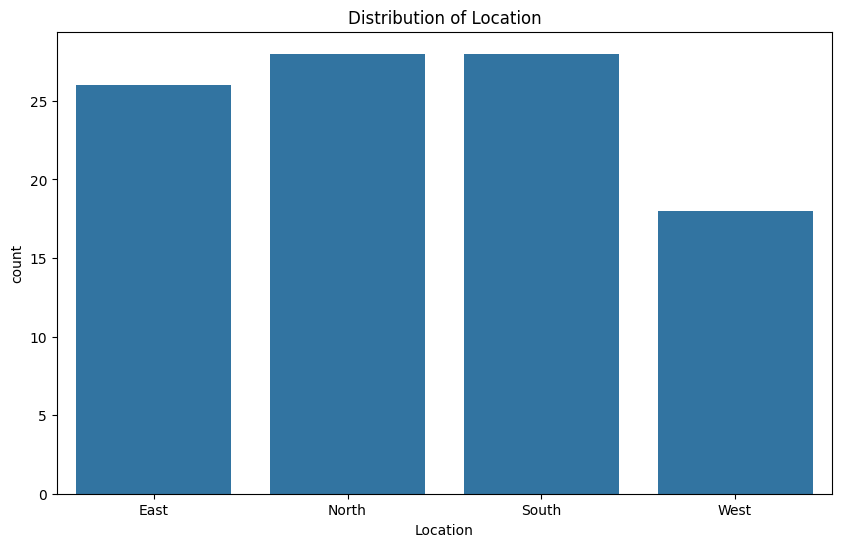

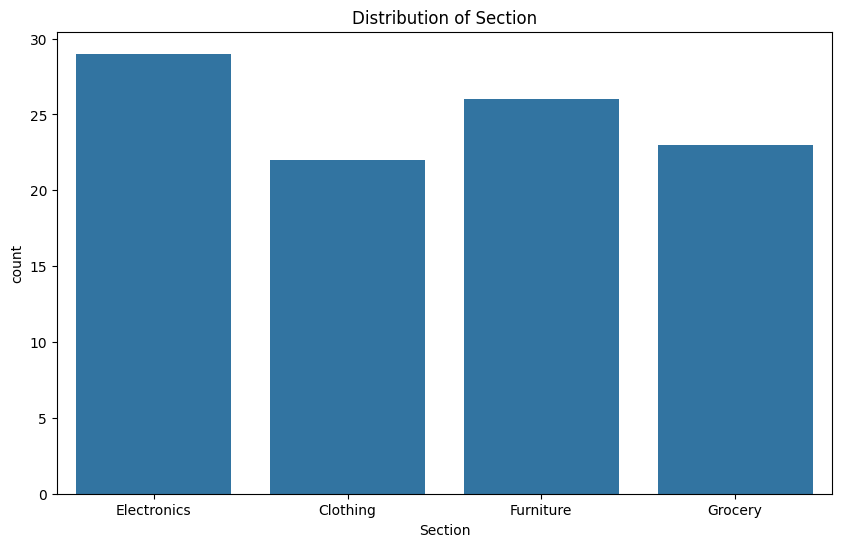

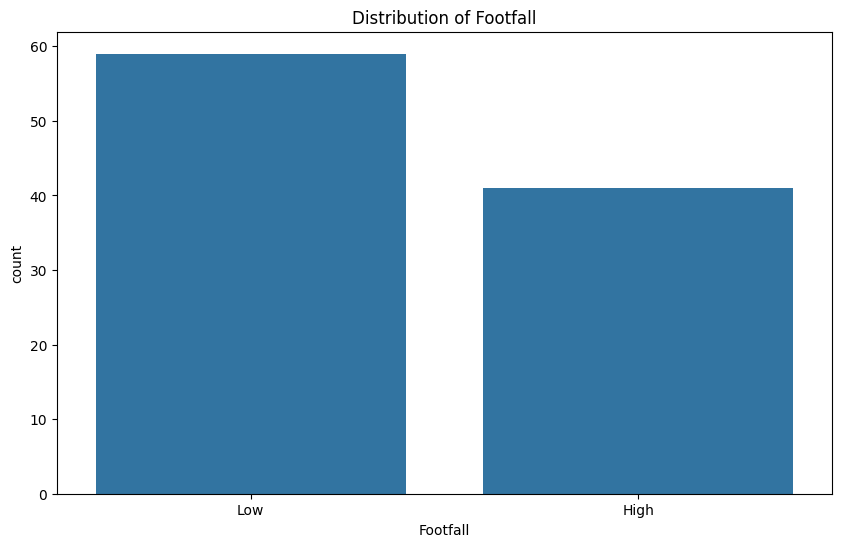

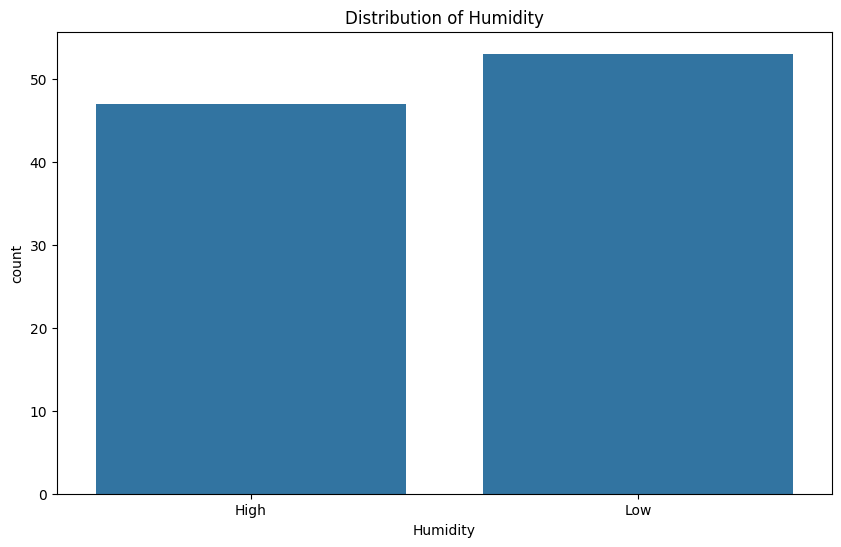

In [59]:
# Categorical features distributions
categorical_features = ['Location', 'Section', 'Footfall', 'Humidity']

for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=train_df, x=feature)
    plt.title(f'Distribution of {feature}')
    plt.show()

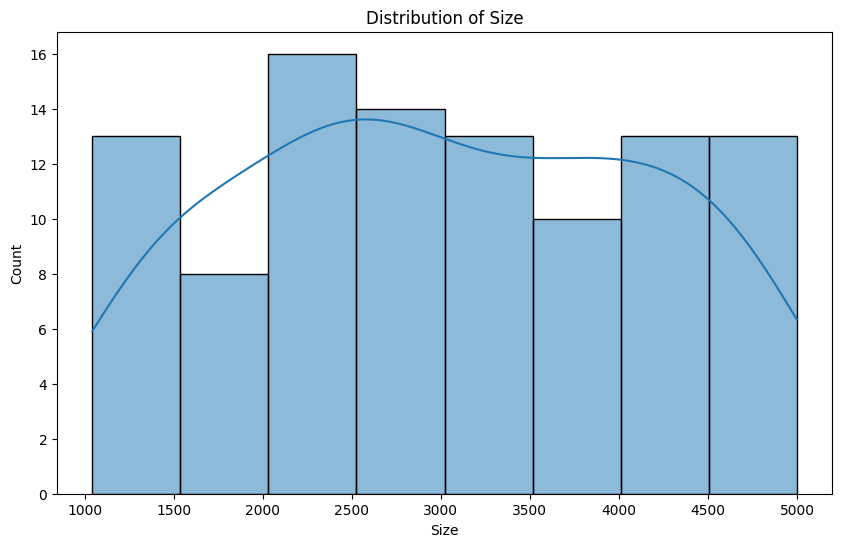

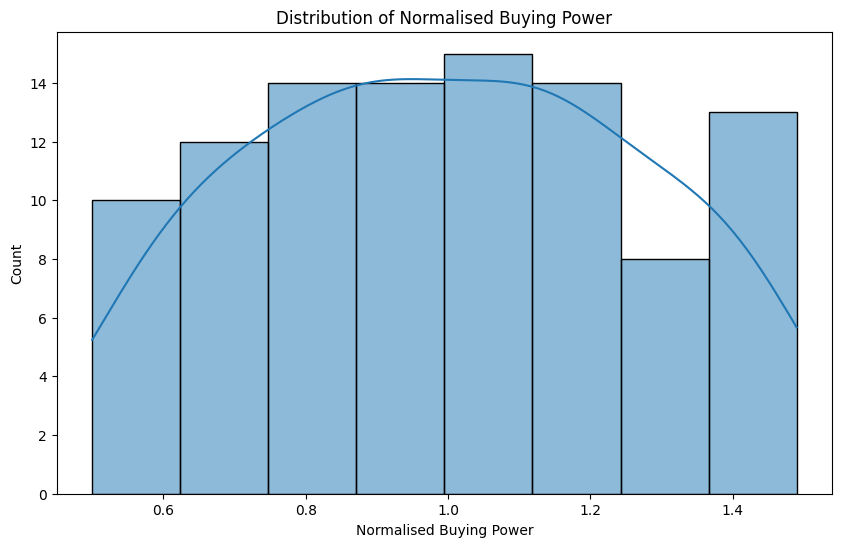

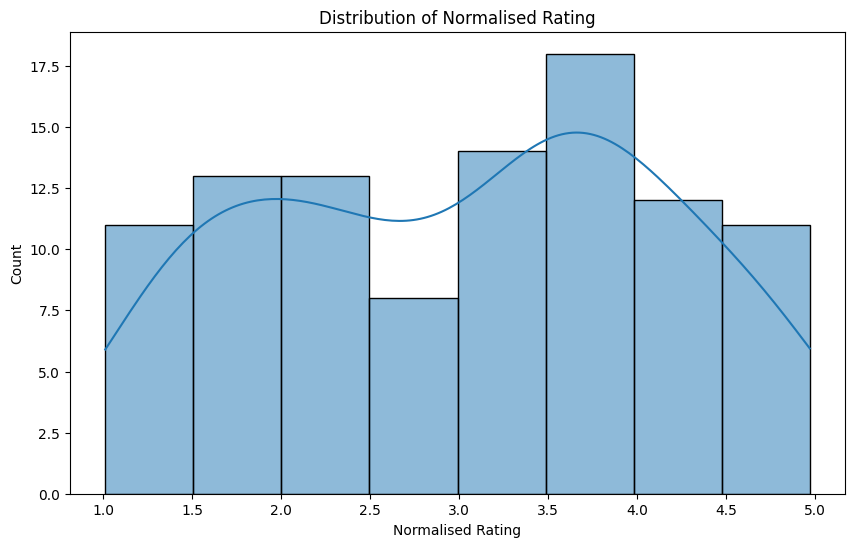

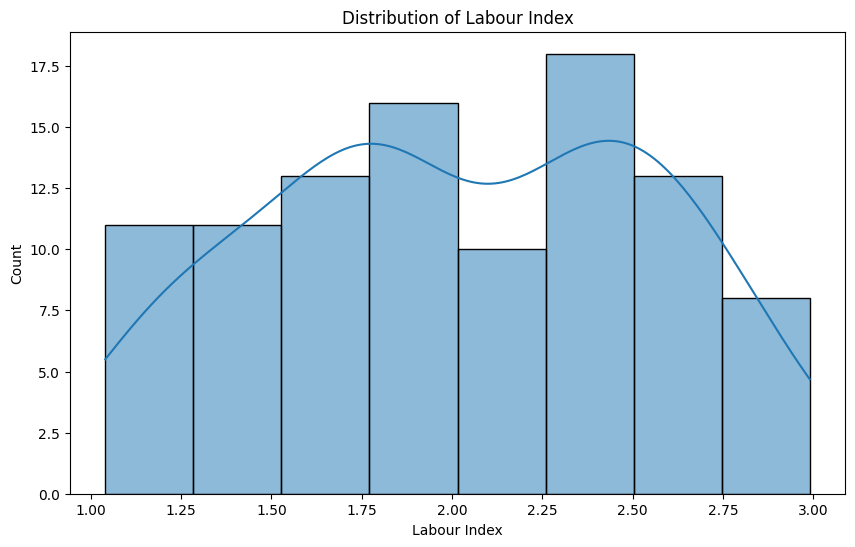

In [60]:
# Distribution of numerical features
numerical_features = ['Size', 'Normalised Buying Power', 'Normalised Rating', 'Labour Index']

for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(train_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

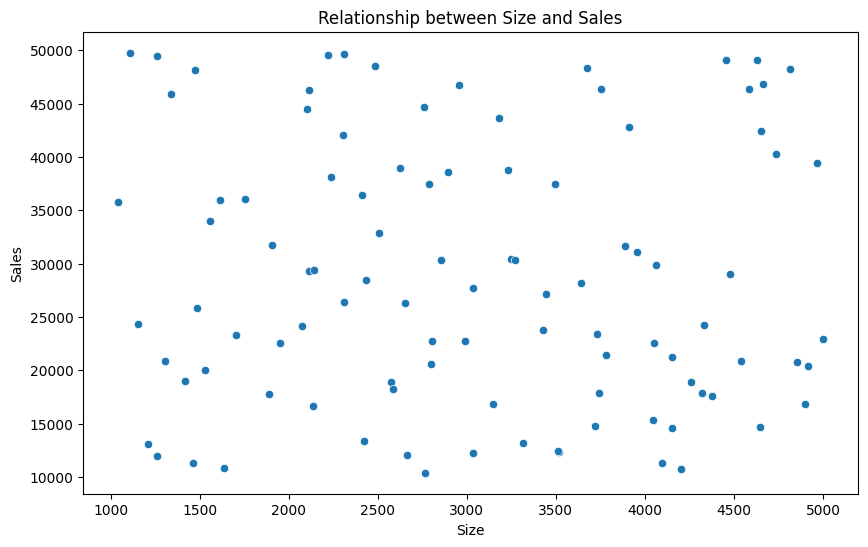

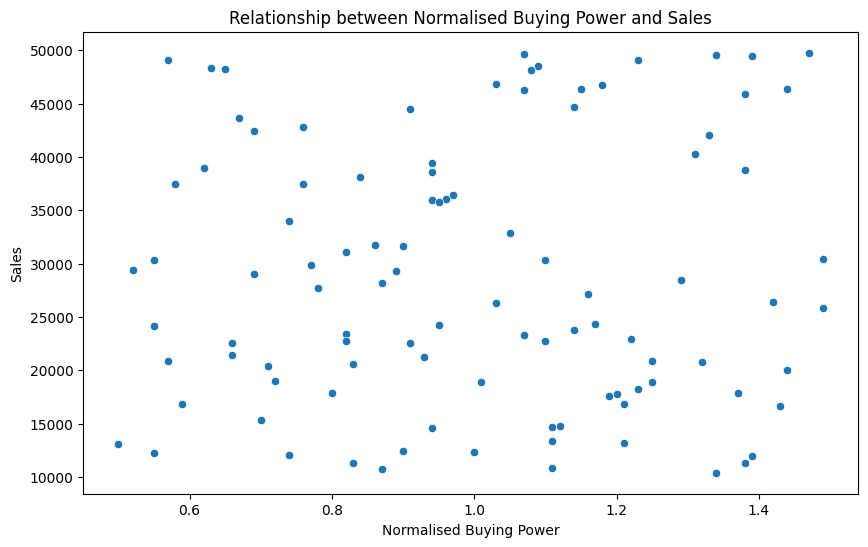

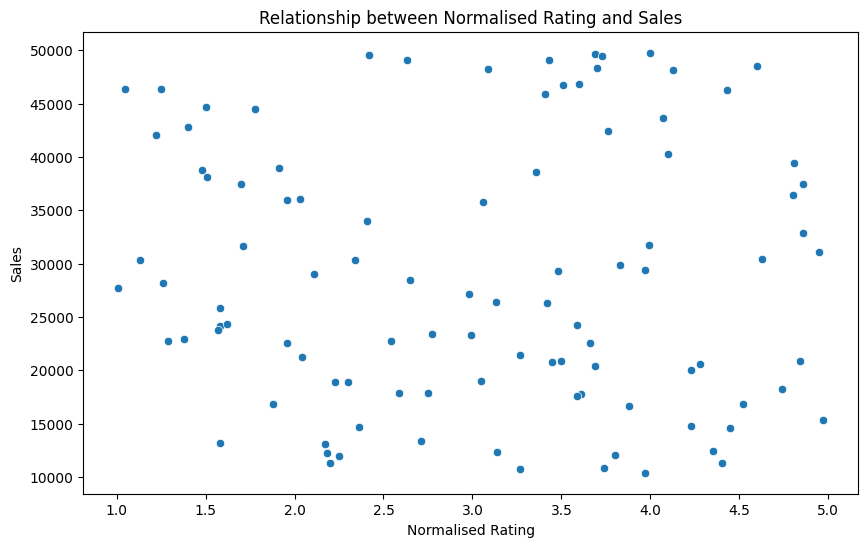

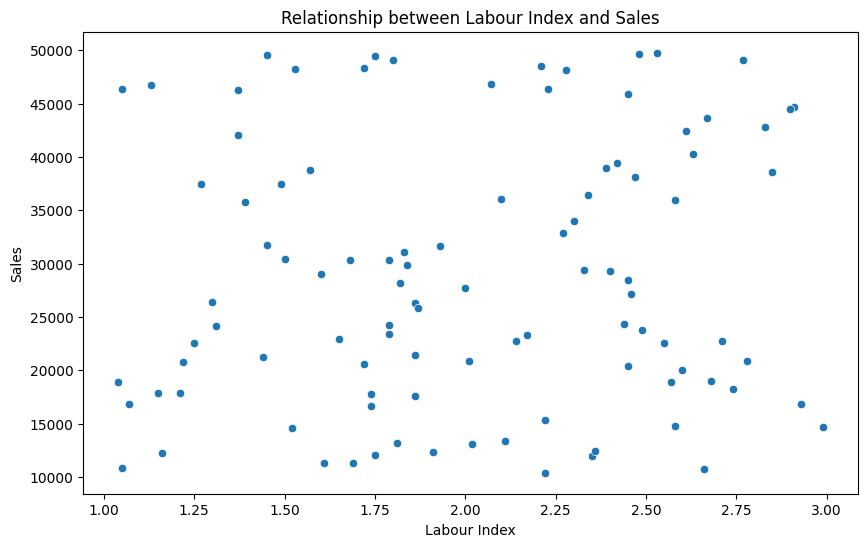

In [61]:
# Relationships between features and Sales
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=train_df, x=feature, y='Sales')
    plt.title(f'Relationship between {feature} and Sales')
    plt.show()

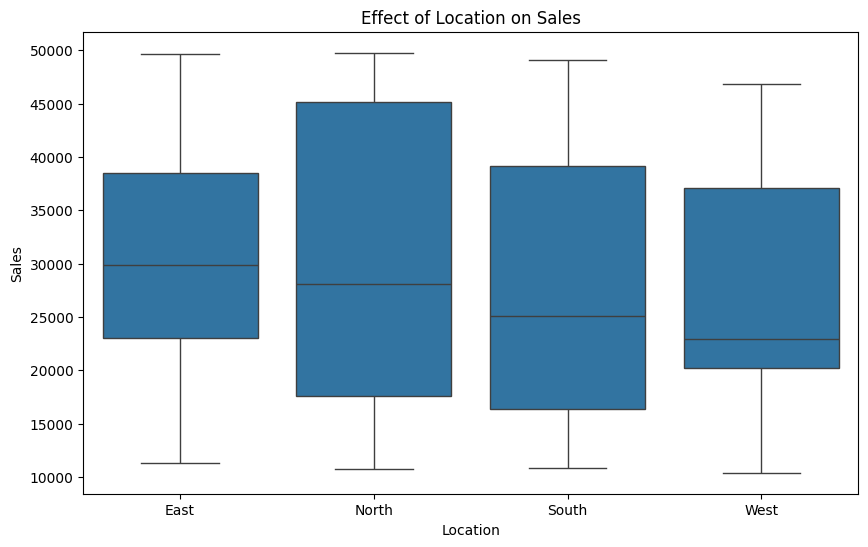

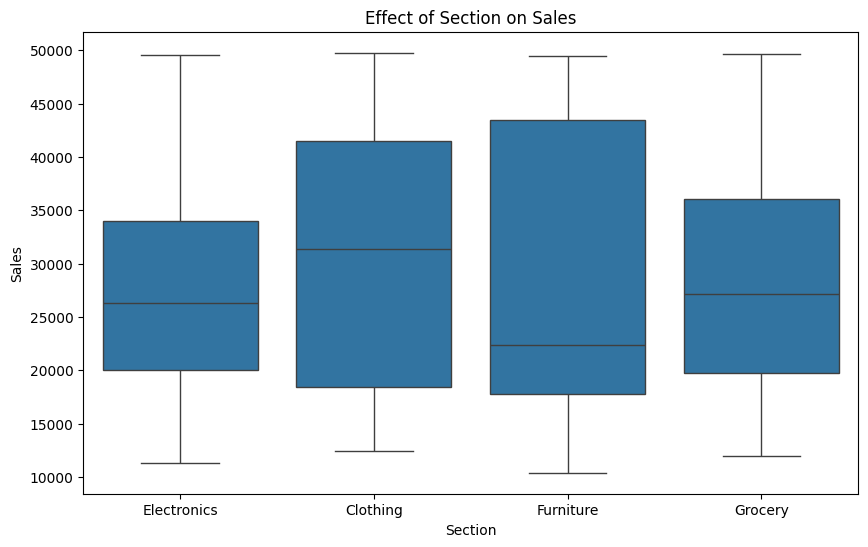

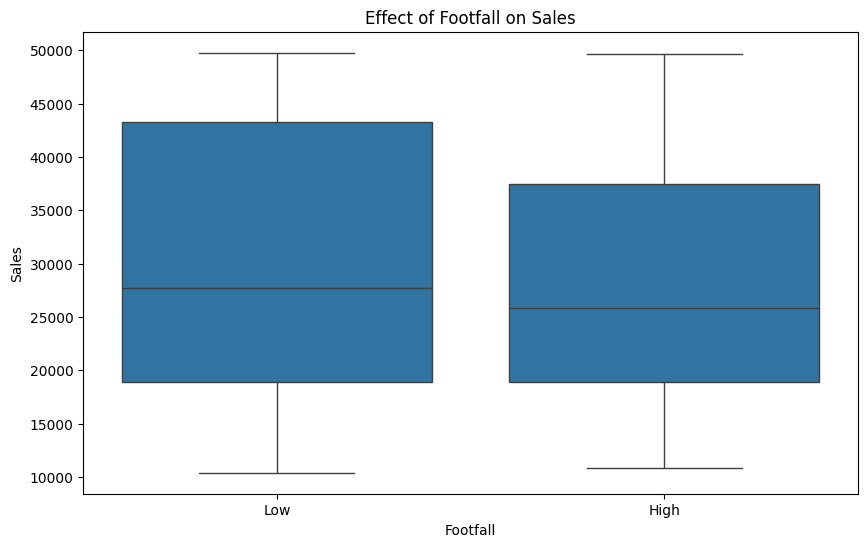

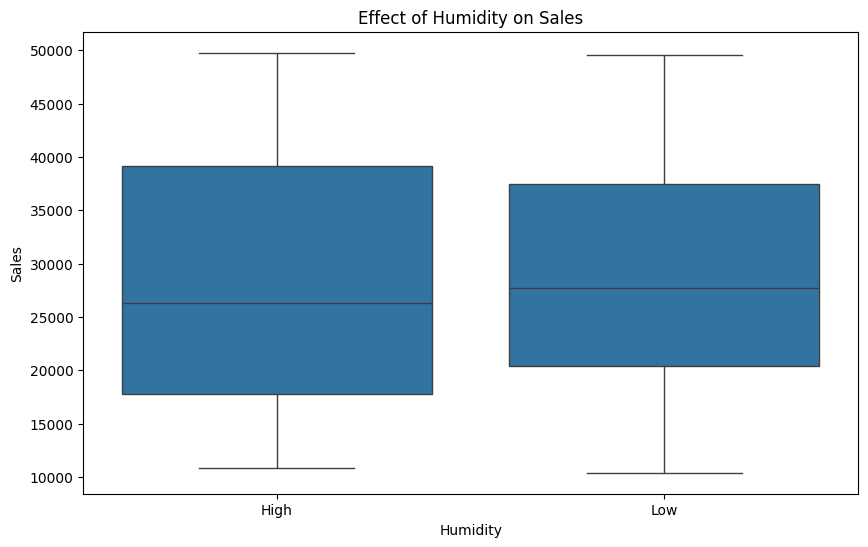

In [62]:
# Boxplots to see the effect of categorical features on Sales
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=train_df, x=feature, y='Sales')
    plt.title(f'Effect of {feature} on Sales')
    plt.show()

In [63]:
# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

In [64]:
# Model definitions
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'Ridge': Ridge(),
    'XGBoost': XGBRegressor(random_state=42)
}

In [65]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
}

In [66]:
# Extended hyperparameter tuning for GradientBoosting and XGBoost
param_grid_gb = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.8, 1.0],
}

param_grid_xgb = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0],
}

In [67]:
# Create a dictionary to hold GridSearchCV objects for each model
grid_searches = {}

In [68]:
# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])
    
    if name == 'RandomForest':
        grid_search = GridSearchCV(pipe, param_grid_rf, cv=kf, scoring='r2', n_jobs=-1, verbose=1)
    elif name == 'GradientBoosting':
        grid_search = GridSearchCV(pipe, param_grid_gb, cv=kf, scoring='r2', n_jobs=-1, verbose=1)
    elif name == 'XGBoost':
        grid_search = GridSearchCV(pipe, param_grid_xgb, cv=kf, scoring='r2', n_jobs=-1, verbose=1)
    else:
        grid_search = GridSearchCV(pipe, {}, cv=kf, scoring='r2', n_jobs=-1, verbose=1)
    
    grid_search.fit(X, y)
    grid_searches[name] = grid_search
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation R^2 score for {name}: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for RandomForest: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Best cross-validation R^2 score for RandomForest: -0.3374
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for GradientBoosting: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}
Best cross-validation R^2 score for GradientBoosting: -0.2359
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Ridge: {}
Best cross-validation R^2 score for Ridge: -0.3349
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters for XGBoost: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}
Best cross-validation R^2 score for XGBoost: -0.2228


In [69]:
# Select the best model based on cross-validation score
best_model_name = max(grid_searches, key=lambda name: grid_searches[name].best_score_)
best_model = grid_searches[best_model_name]

In [70]:
# Validate the best model on a hold-out validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)
print(f"R^2 Score on validation set for {best_model_name}: {r2_score(y_val, y_pred):.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
R^2 Score on validation set for XGBoost: -0.2237


In [71]:
# Make predictions on the test set
test_preds = best_model.predict(X_test)

In [72]:
# Save the trained model to a file
filename = 'trained_model.pkl'
joblib.dump(best_model, filename)

['trained_model.pkl']